In [1]:
# 如果离开研究平台在本地运行，需要安装FMZ包
# pip install https://github.com/fmzquant/backtest_python/archive/master.zip

In [2]:
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from pylab import mpl

In [3]:
'''
start: 2020-05-11 00:00:00
end: 2020-08-08 00:00:00
period: 1d
exchanges: [{"eid":"OKEX","currency":"BTC_USDT","stocks":0}]
'''
#上面注释是回测设置
from fmz import * # 导入所有FMZ函数
task = VCtx(__doc__) # 初始化

In [4]:
kline = get_bars('futures_bitmex.bxbt', '1d', start='2018-01-01', end='2020-08-08')
kline

,open,high,low,close,volume
2018-01-01 08:00:00+08:00,13871.60,13915.10,12900.20,13461.70,0
2018-01-02 08:00:00+08:00,13461.70,15263.20,12982.50,14730.20,0
2018-01-03 08:00:00+08:00,14730.20,15380.00,14594.30,15126.90,0
2018-01-04 08:00:00+08:00,15126.90,15397.50,14218.10,15144.30,0
2018-01-05 08:00:00+08:00,15144.30,17134.00,14822.00,16944.00,0
...,...,...,...,...,...
2020-08-03 08:00:00+08:00,11068.22,11479.92,10979.53,11237.29,0
2020-08-04 08:00:00+08:00,11235.31,11417.59,11037.63,11195.82,0
2020-08-05 08:00:00+08:00,11195.82,11790.94,11107.42,11754.92,0
2020-08-06 08:00:00+08:00,11754.92,11909.71,11585.20,11773.03,0


In [5]:
# 提取开盘价、收盘价、最高价和最低价
open_data = kline.open
close_data = kline.close
high_data = kline.high
low_data = kline.low
# 计算收益率
r_data=close_data/close_data.shift(1)-1
r_data=r_data[1:]
new_index=pd.date_range("2018-01-02", "2020-08-07", freq="D")
r_data.index=new_index

In [6]:
#计算自相关系数，设置滞后项为5期
open_acf=smt.stattools.acf(open_data,nlags=5)
#计算偏自相关系数
open_pacf=smt.stattools.pacf(open_data,nlags=5)

close_acf=smt.stattools.acf(close_data,nlags=5)
close_pacf=smt.stattools.pacf(close_data,nlags=5)

high_acf=smt.stattools.acf(high_data,nlags=5)
high_pacf=smt.stattools.pacf(high_data,nlags=5)

low_acf=smt.stattools.acf(low_data,nlags=5)
low_pacf=smt.stattools.pacf(low_data,nlags=5)

r_acf=smt.stattools.acf(r_data,nlags=5)
r_pacf=smt.stattools.pacf(r_data,nlags=5)

# 下面的warning是有关api更新的提醒

/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


In [7]:
print(open_acf)
print(open_pacf)

print(close_acf)
print(close_pacf)

print(high_acf)
print(high_pacf)

print(low_acf)
print(low_pacf)

print(r_acf)
print(r_pacf)


[1.         0.98395117 0.97009466 0.95442678 0.93788479 0.92192099]
[ 1.          0.984988    0.06510079 -0.0634793  -0.04657373  0.00917528]
[1.         0.98446703 0.9690914  0.952501   0.93589431 0.91769069]
[ 1.          0.98550441 -0.00288533 -0.05066576 -0.01010258 -0.0633347 ]
[1.         0.98770158 0.97198675 0.95673947 0.94166291 0.92401007]
[ 1.          0.98874236 -0.15963967  0.03649916 -0.01084355 -0.12708396]
[1.         0.98403474 0.96547567 0.94854502 0.93141134 0.91377787]
[ 1.          0.98507166 -0.0962964   0.0532187  -0.02683084 -0.02088416]
[ 1.         -0.10720916  0.07711582 -0.00733256  0.01642066  0.01659501]
[ 1.         -0.10732225  0.06652688  0.00764751  0.01155422  0.01971016]


In [ ]:
#日线数据自相关系数呈现缓慢减小过程， 而偏自相关系数一阶约等于1，然后迅速减小，初步判断日线数据不符合平稳性时间序列特征。

In [8]:
# 绘制时序图、自相关系数图、偏自相关系数图、QQ图和PP图
def ts_plot(data, lags=None,title=''):
    
    if not isinstance(data, pd.Series):   
        data = pd.Series(data)
    with plt.style.context('ggplot'):    
        fig = plt.figure(figsize=(10, 8))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        data.plot(ax=ts_ax)
        ts_ax.set_title(title+'Time Series')
        smt.graphics.plot_acf(data, lags=lags, ax=acf_ax, alpha=0.5)
        acf_ax.set_title('ACF')
        smt.graphics.plot_pacf(data, lags=lags, ax=pacf_ax, alpha=0.5)
        pacf_ax.set_title('PACF')
        sm.qqplot(data, line='s', ax=qq_ax)
        qq_ax.set_title('QQ')        
        scs.probplot(data, sparams=(data.mean(), 
                     data.std()), plot=pp_ax)
        pp_ax.set_title('PP') 
        plt.tight_layout()
    return

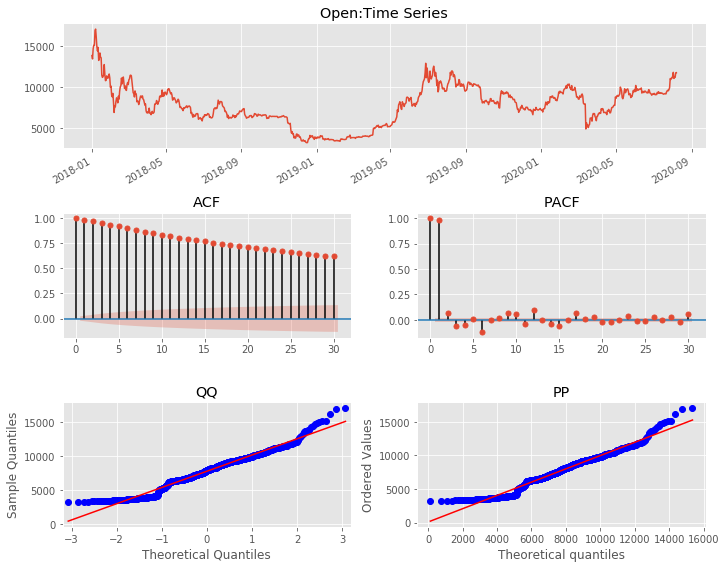

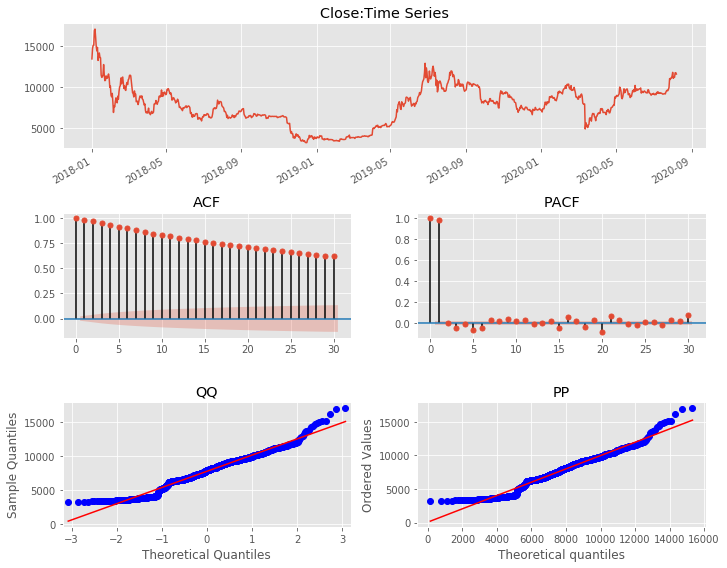

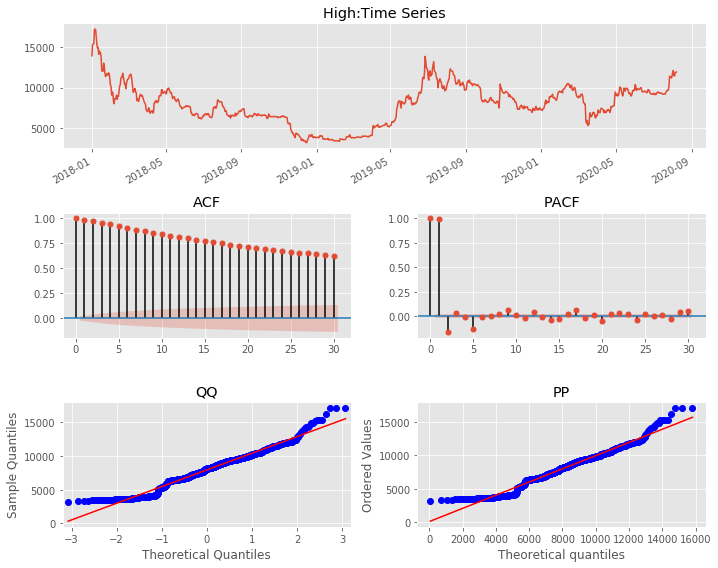

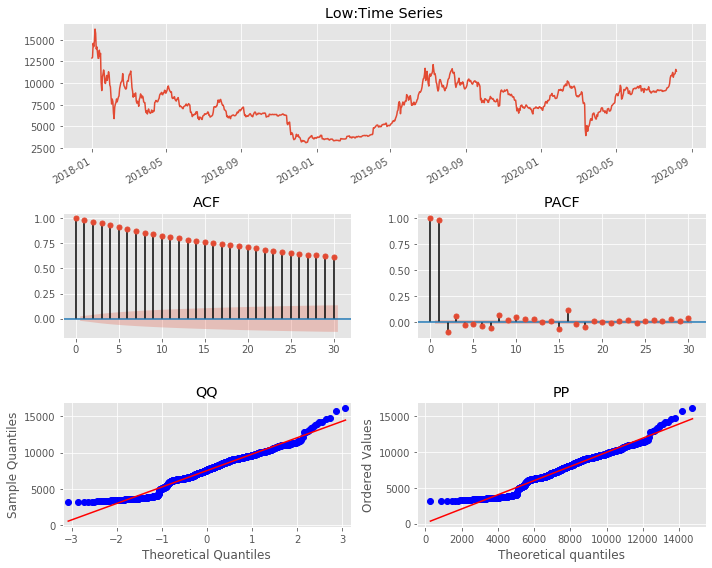

In [9]:
ts_plot(open_data, lags=30,title='Open:')
ts_plot(close_data, lags=30,title='Close:')
ts_plot(high_data, lags=30,title='High:')
ts_plot(low_data, lags=30,title='Low:')
# 日线数据走势存在明显递增、递减或周期性波动，时间序列很可能是不平稳的。
# 此外，从QQ图和PP图上不难看出，日线数据时间序列不符合正态分布

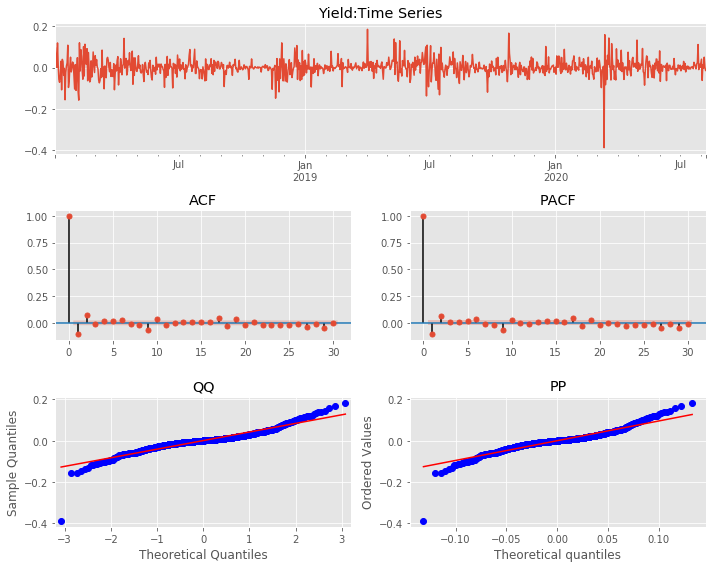

In [10]:
ts_plot(r_data, lags=30,title='Yield:')
# 收益率时序图围绕某一水平线上下以大致相同的幅度波动，自相关与偏自相关系数快速减小至0附近或在某一阶后变为0，从图形上观察应该是平稳过程。
# 从QQ图和概率图上看，该过程很像标准正态分布但是存在厚尾。

In [12]:
# ADF检验，判断平稳性
from arch.unitroot import ADF
print(ADF(open_data))
from arch.unitroot import ADF
print(ADF(close_data))
from arch.unitroot import ADF
print(ADF(high_data))
from arch.unitroot import ADF
print(ADF(low_data))

from arch.unitroot import ADF
print(ADF(r_data))

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.853
P-value                         0.051
Lags                                2
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
   Augmented Dickey-Fuller Results   
Test Statistic                 -3.024
P-value                         0.033
Lags                                2
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
   Augmented Dickey-Fuller Results   
Test Statistic                 -3.646
P-value                         0.005
Lags                                4
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Nu

In [13]:
# 开盘价和最低价的p值大于0.5，收盘价、最高价的p值小于0.5。因此，在5%的置信水平上，开盘价和最低价为非平稳序列，其余为平稳序列。
# 收益率的p值接近于0，为平稳序列

/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


最佳滞后阶数:(2, 0)
                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                  949
Model:                     ARMA(2, 0)   Log Likelihood                1678.832
Method:                           mle   S.D. of innovations              0.041
Date:                Tue, 11 Aug 2020   AIC                          -3351.664
Time:                        20:31:35   BIC                          -3337.098
Sample:                    01-02-2018   HQIC                         -3346.114
                         - 08-07-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ar.L1.close    -0.1001      0.032     -3.083      0.002      -0.164      -0.036
ar.L2.close     0.0667      0.032      2.056      0.040       0.003       0.130
                                  

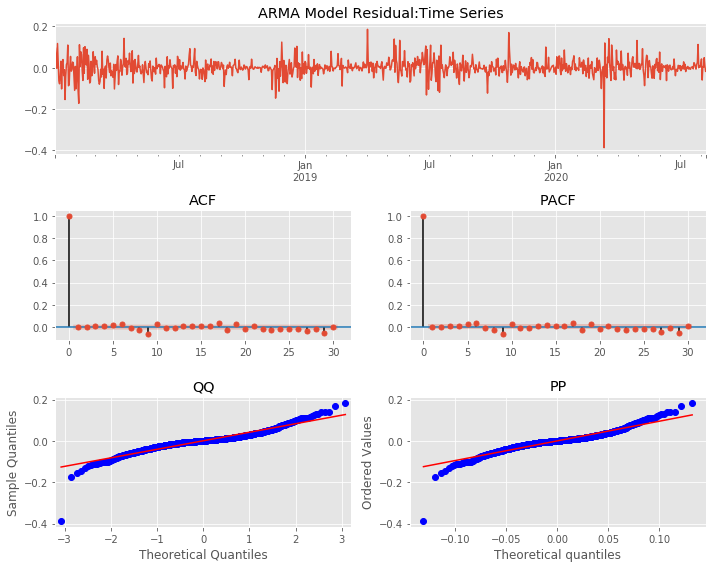

In [14]:
# 收益率序列平稳，无需差分。因为收益率ACF为拖尾，PACF为一阶截尾，因此应选用AR模型。
# 用ARMA模型拟合，最佳模型p=2,q=0，符合猜想，应选用AR(2)模型
best_aic = np.inf 
best_order = None
best_mdl = None
rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(r_data, order=(i,j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue
            
print(f'最佳滞后阶数:{best_order}')
print(best_mdl.summary())
resid=pd.Series(best_mdl.resid,index=r_data.index)
ts_plot(resid, lags=30,title='ARMA Model Residual:')

In [15]:
# 检验是否属于白噪声
def whitenoise_test(ts):
    '''计算box pierce 和 box ljung统计量'''
    from statsmodels.stats.diagnostic import acorr_ljungbox
    q,p=acorr_ljungbox(ts)
    with plt.style.context('ggplot'):
        fig = plt.figure(figsize=(10, 4))
        axes = fig.subplots(1,2)
        axes[0].plot(q, label='Q Statistics')
        axes[0].set_ylabel('Q')
        axes[1].plot(p, label='p Value')
        axes[1].set_ylabel('P')
        axes[0].legend()
        axes[1].legend()
        plt.tight_layout()

    return

/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/stats/diagnostic.py:496: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  "lags to silence this warning.", FutureWarning)
/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


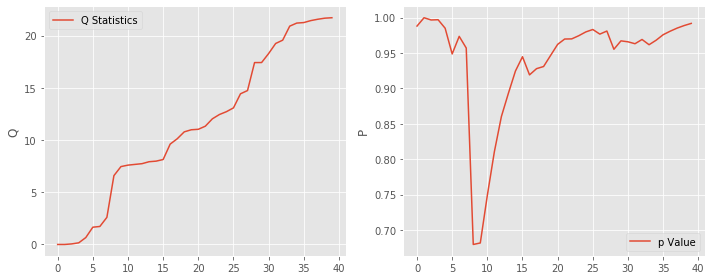

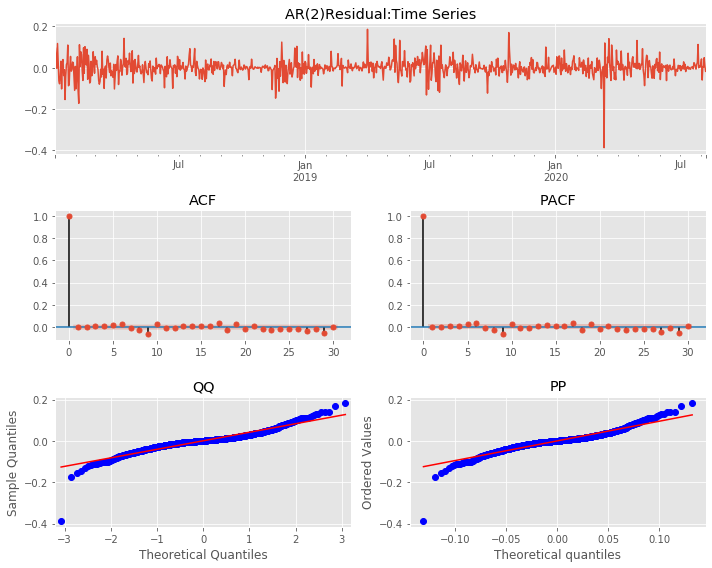

In [16]:
whitenoise_test(resid)
ts_plot(resid, lags=30,title='AR(2)Residual:')
# p值大于0.5，残差通过了白噪声检验，证明残差属于白噪声序列。
# 但从残差时序图来看，存在波动聚集性。从QQ图和PP图来看，存在厚尾现象。因此需要检验残差的平方，判断是否具有ARCH效应。

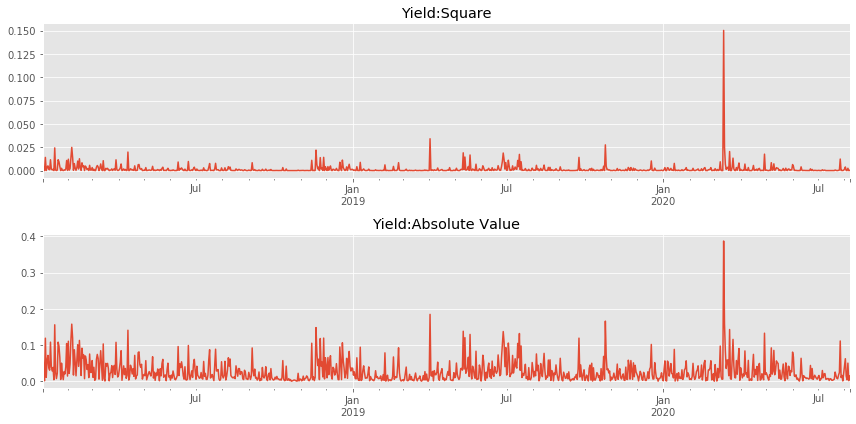

In [17]:
# 绘制日收益平方和绝对值走势图
def r_plot(ts, title=''):
    ts1=ts**2
    ts2=np.abs(ts)
    with plt.style.context('ggplot'):
        fig = plt.figure(figsize=(12, 6))
        layout = (2, 1)
        ts1_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        ts2_ax = plt.subplot2grid(layout, (1, 0))
        ts1.plot(ax=ts1_ax)
        ts1_ax.set_title(title+'Square')
        ts2.plot(ax=ts2_ax)
        ts2_ax.set_title(title+'Absolute Value')
        plt.tight_layout()
    return
r_plot(r_data, title='Yield:')
# 从日收益平方和绝对值走势图可以看出，存在较明显的波动聚集的现象，初步可以判断出收益率序列存在ARCH效应。

/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/stats/diagnostic.py:496: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  "lags to silence this warning.", FutureWarning)
/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


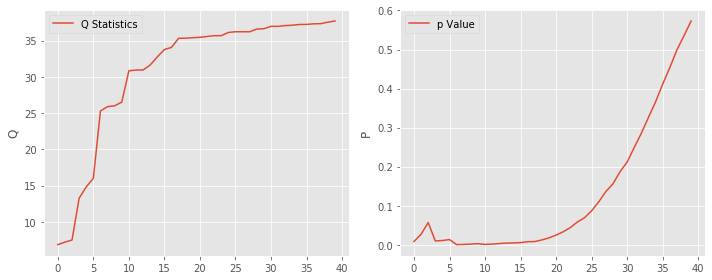

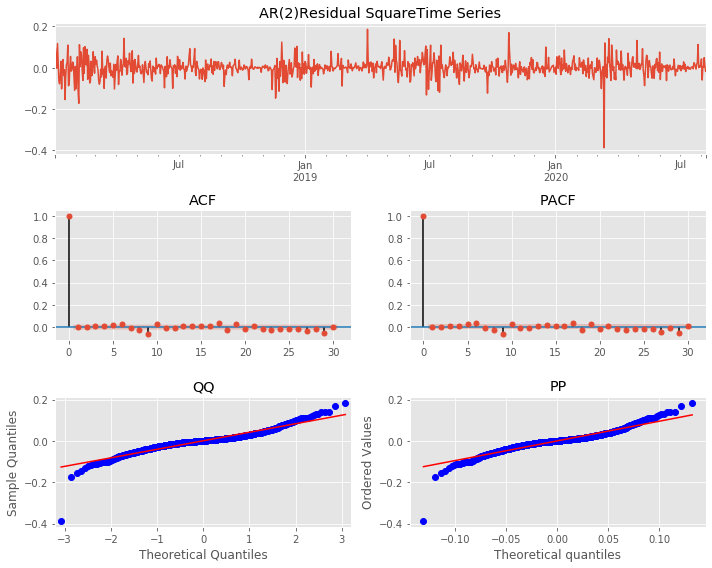

In [18]:
whitenoise_test(resid**2)
ts_plot(resid, lags=30,title='AR(2)Residual Square')
# 由白噪声检验可以看出，Q统计量的p值基本都在0.05以下, 可以拒绝残差的平方是白噪音序列的原假设，说明收益率序列存在ARCH效应。

In [19]:
adjusted_r_data=r_data*100
# 用ARCH模型拟合收益率序列,根据AR模型拟合结果、ACF图和PACF图，选择ARCH(2)
arch = arch_model(adjusted_r_data,vol='Arch', p=2, o=0, q=0, dist='StudentsT')
ar_res = arch.fit(update_freq=0)
# 用GARCH模型拟合收益率序列,根据AR模型拟合结果、ACF图和PACF图，选择GARCH(1,1)
garch = arch_model(adjusted_r_data,p=1, o=0, q=1, dist='StudentsT')
gar_res = garch.fit(update_freq=0)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2545.5334012626236
            Iterations: 29
            Function evaluations: 216
            Gradient evaluations: 29
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2497.0453071094316
            Iterations: 20
            Function evaluations: 157
            Gradient evaluations: 20


In [20]:
print(ar_res.summary())
print(gar_res.summary())
# 对于ARCH模型，alpha1为0.6794，alpha2为0.3206
# 对于GARCH模型，alpha1为0.0728，beta1为0.9272

                         Constant Mean - ARCH Model Results                         
Dep. Variable:                        close   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                             ARCH   Log-Likelihood:               -2545.53
Distribution:      Standardized Student's t   AIC:                           5101.07
Method:                  Maximum Likelihood   BIC:                           5125.34
                                              No. Observations:                  949
Date:                      Tue, Aug 11 2020   Df Residuals:                      944
Time:                              20:32:48   Df Model:                            5
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

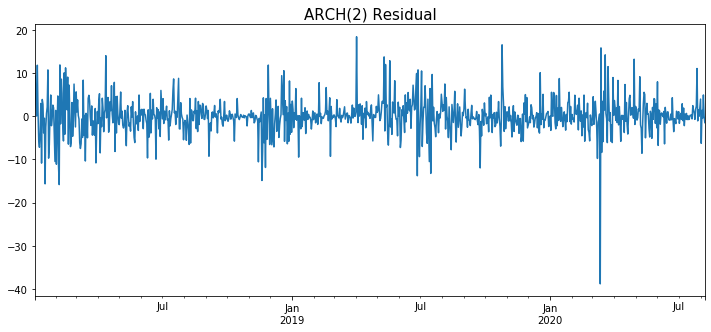

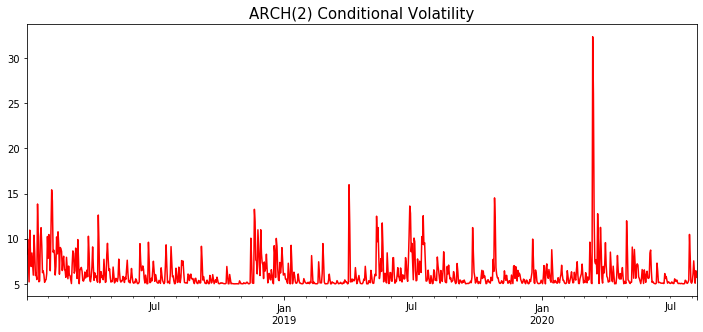

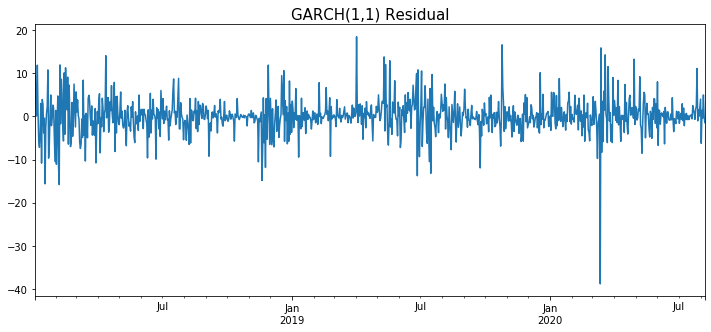

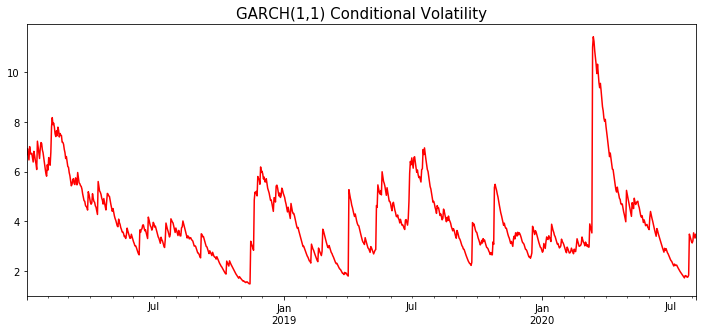

In [21]:
ar_res.resid.plot(figsize=(12,5))
plt.title('ARCH(2) Residual',size=15)
plt.show()
ar_res.conditional_volatility.plot(figsize=(12,5),color='r')
plt.title('ARCH(2) Conditional Volatility',size=15)
plt.show()
gar_res.resid.plot(figsize=(12,5))
plt.title('GARCH(1,1) Residual',size=15)
plt.show()
gar_res.conditional_volatility.plot(figsize=(12,5),color='r')
plt.title('GARCH(1,1) Conditional Volatility',size=15)
plt.show()
# GARCH模型条件方差的波动较小

/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/stats/diagnostic.py:496: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  "lags to silence this warning.", FutureWarning)
/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)
/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/stats/diagnostic.py:496: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  "lags to silence this warning.", FutureWarning)
/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-

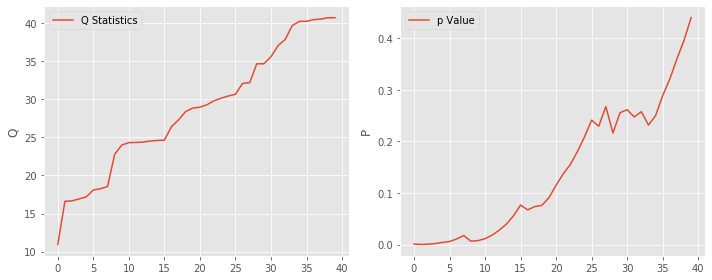

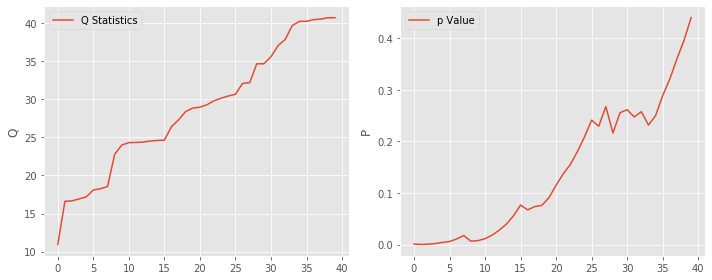

In [22]:
whitenoise_test(ar_res.resid)
whitenoise_test(gar_res.resid)
#ARCH和GARCH模型的p值基本大于0.5，两个模型几乎相同

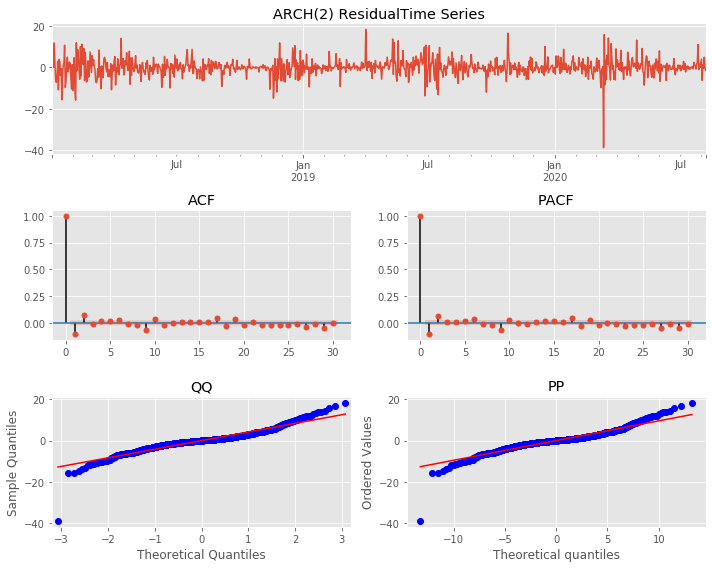

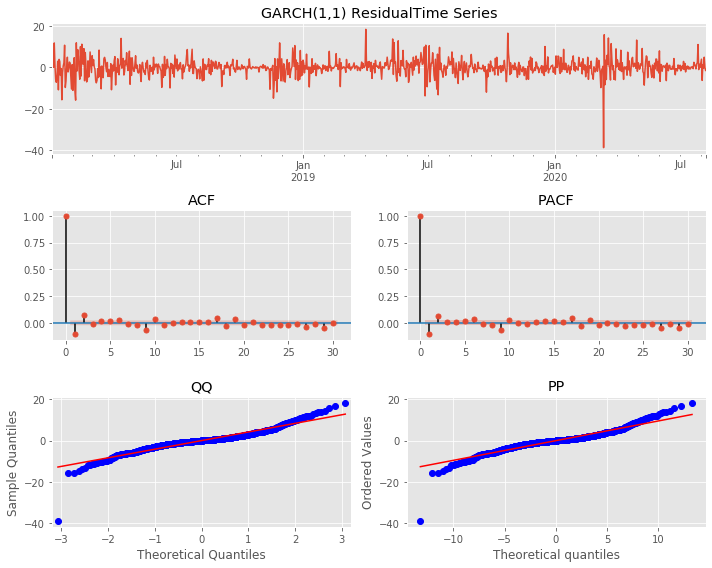

In [23]:
ts_plot(ar_res.resid, lags=30,title='ARCH(2) Residual')
ts_plot(gar_res.resid, lags=30,title='GARCH(1,1) Residual')
# 厚尾现象有一定改善，但依然明显；波动聚集性没有明显改善

In [24]:
# 综上所述，ARCH和GARCH对于收率厚尾现象有一定的刻画能力，但并不能很好的说明收益率的波动聚集性。
# 从白噪声检验可以看出，收益率确实存在ARCH，但ARCH和GARCH模型拟合后的残差依然不能完全通过白噪声检验。
# 要充分刻画厚尾和波动聚集性，或需要加入其他模型。